# Image Classification Project - Edge Impulse
By MJRovai @19Aug25

## Import Libraries

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tflite_runtime.interpreter as tflite

/home/mjrovai/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Models to test

In [88]:
!ls ./models

cifar10_quant.tflite
cifar10.tflite
ei-periquito-vs-robot-img-class-int8-quantized-model.lite
ei-raspi-img-class-float32-model.tflite
ei-raspi-img-class-int8-quantized-model.tflite
labels.txt
mobilenet_v2_1.0_224_quant.tflite


## Test Dataset

In [3]:
!ls ./dataset

background  periquito  robot


In [4]:
!ls ./dataset/background

background.jpg


In [6]:
!ls ./dataset/periquito

image_20250819-090401.jpg  image_20250819-090408.jpg  image_20250819-090412.jpg
image_20250819-090405.jpg  image_20250819-090410.jpg


In [7]:
!ls ./dataset/robot

image_20250819-090429.jpg  image_20250819-090431.jpg  image_20250819-090434.jpg


## Inspect Model

In [8]:
labels = ['background', 'periquito', 'robot']

In [9]:
img_path = "./dataset/robot/image_20250819-090429.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"

In [12]:
    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

In [13]:
input_details

[{'name': 'serving_default_x:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3], dtype=int32),
  'shape_signature': array([  1, 160, 160,   3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [14]:
 output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 177,
  'shape': array([1, 3], dtype=int32),
  'shape_signature': array([1, 3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.00390625, -128),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [15]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.int8

Now, the model is expecting a 'int8' dtype, what means that we should adapt the input image:

/usr/lib/python3/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/lib/python3/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


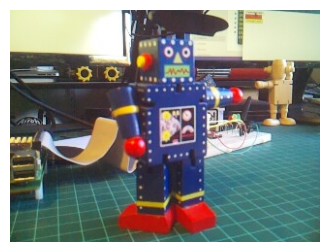

In [16]:
img = Image.open(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Pre-Processing

In [17]:
scale, zero_point = input_details[0]['quantization']
img = img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
input_data = np.expand_dims(img_array, axis=0)
input_data.shape, input_data.dtype

((1, 160, 160, 3), dtype('int8'))

## Inference

In [18]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 162.2ms


In [19]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]
predictions

array([-128, -128,  127], dtype=int8)

In [20]:
# Get indices of the top k results
top_k_results=3
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]
top_k_indices

array([2, 1, 0])

In [21]:
# Get quantization parameters
scale, zero_point = output_details[0]['quantization']

# Dequantize the output
dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
dequantized_output

array([0.        , 0.        , 0.99609375], dtype=float32)

The model already has a softmax in its output, and so, we can use its raw output as the "probabilities".

In [22]:
# exp_output = np.exp(dequantized_output - np.max(dequantized_output))
# probabilities = exp_output / np.sum(exp_output)
probabilities = dequantized_output

In [24]:
print("\n\t[PREDICTION]        [Prob]\n")
for i in range(top_k_results):
    print("\t{:20}: {:.2f}%".format(
        labels[top_k_indices[i]],
        probabilities[top_k_indices[i]] * 100))


	[PREDICTION]        [Prob]

	robot               : 99.61%
	periquito           : 0.00%
	background          : 0.00%


Let's use a non quantized model

In [52]:
img_path = "./dataset/periquito/image_20250819-090410.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"

In [53]:
    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

In [54]:
input_details

[{'name': 'serving_default_x:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3], dtype=int32),
  'shape_signature': array([  1, 160, 160,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [55]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 177,
  'shape': array([1, 3], dtype=int32),
  'shape_signature': array([1, 3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

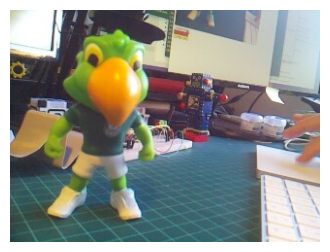

In [56]:
img = Image.open(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [57]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.float32

Now, the model is expecting an input as a float32, so, let's normalize the data to [0,1]. 

In [58]:
img = img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
img_array = np.array(img, dtype=np.float32) / 255.0
input_data = np.expand_dims(img_array, axis=0)
input_data.shape, input_data.dtype

((1, 160, 160, 3), dtype('float32'))

In [59]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 107.0ms


In [60]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]

In [61]:
predictions

array([1.3514797e-13, 1.0000000e+00, 4.6989888e-09], dtype=float32)

In [62]:
# Get indices of the top k results
top_k_results=3
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

In [63]:
top_k_indices

array([1, 2, 0])

In [64]:
print("\n\t[PREDICTION]        [Prob]\n")
for i in range(top_k_results):
    print("\t{:20}: {}%".format(
        labels[top_k_indices[i]],
            (int(predictions[top_k_indices[i]]*100))))


	[PREDICTION]        [Prob]

	periquito           : 100%
	robot               : 0%
	background          : 0%


### Function to handle any type of models 

In [84]:
def image_classification(img_path, model_path, labels, top_k_results=3, apply_softmax=False):
    # Load the image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    
    input_dtype = input_details[0]['dtype']
    
    if input_dtype == np.uint8:
        input_data = np.expand_dims(np.array(img), axis=0)
    elif input_dtype == np.int8:
        scale, zero_point = input_details[0]['quantization']
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
        input_data = np.expand_dims(img_array, axis=0)
    else:  # float32
        input_data = np.expand_dims(np.array(img, dtype=np.float32), axis=0) / 255.0

    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds

    # Obtain results
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    # Handle output based on type
    output_dtype = output_details[0]['dtype']
    if output_dtype in [np.int8, np.uint8]:
        # Dequantize the output
        scale, zero_point = output_details[0]['quantization']
        predictions = (predictions.astype(np.float32) - zero_point) * scale
    
    if apply_softmax:
        # Apply softmax
        exp_preds = np.exp(predictions - np.max(predictions))
        probabilities = exp_preds / np.sum(exp_preds)
    else:
        probabilities = predictions

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {:.1f}%".format(
            labels[top_k_indices[i]],
            probabilities[top_k_indices[i]] * 100))
    print ("\n\tInference time: {:.1f}ms".format(inference_time))

# Usage:
# image_classification('path_to_image.jpg', 'path_to_model.tflite', labels)


	[PREDICTION]        [Prob]

	periquito           : 99.6%
	robot               : 0.0%
	background          : 0.0%

	Inference time: 121.3ms


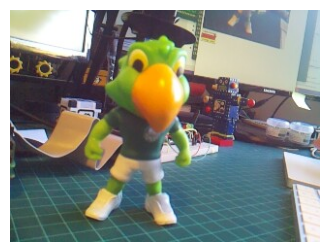

In [68]:
img_path = "./dataset/periquito/image_20250819-090412.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	periquito           : 100.0%
	robot               : 0.0%
	background          : 0.0%

	Inference time: 102.1ms


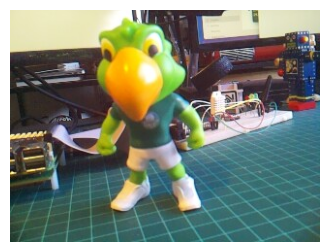

In [74]:
img_path = "./dataset/periquito/image_20250819-090408.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	robot               : 99.6%
	periquito           : 0.0%
	background          : 0.0%

	Inference time: 131.3ms


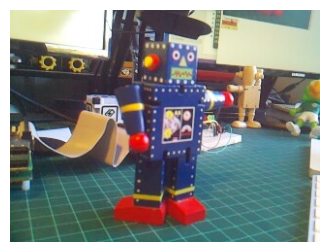

In [70]:
img_path = "./dataset/robot/image_20250819-090431.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	robot               : 100.0%
	periquito           : 0.0%
	background          : 0.0%

	Inference time: 103.3ms


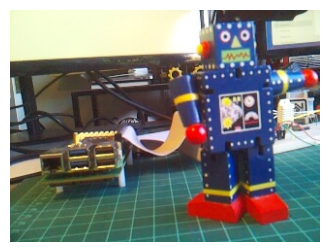

In [71]:
img_path = "./dataset/robot/image_20250819-090434.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	background          : 99.6%
	robot               : 0.0%
	periquito           : 0.0%

	Inference time: 121.0ms


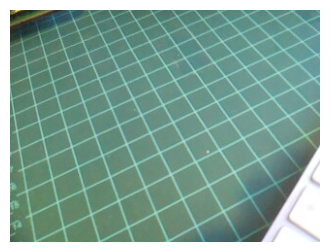

In [72]:
img_path = "./dataset/background/background.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	background          : 100.0%
	periquito           : 0.0%
	robot               : 0.0%

	Inference time: 101.9ms


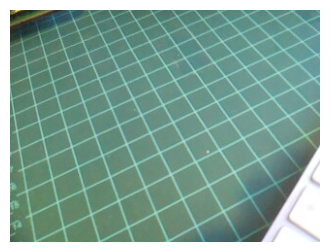

In [73]:
img_path = "./dataset/background/background.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))

## Testing a smaller model (optional)

Model can be downloded from: https://studio.edgeimpulse.com/public/353482/live


	[PREDICTION]        [Prob]

	periquito           : 98.8%
	background          : 1.2%
	robot               : 0.0%

	Inference time: 13.7ms


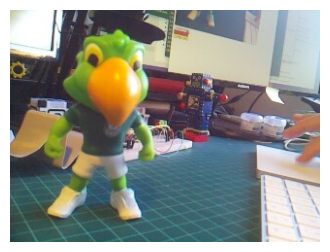

In [76]:
img_path = "./dataset/periquito/image_20250819-090410.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	robot               : 74.6%
	periquito           : 25.0%
	background          : 0.4%

	Inference time: 10.9ms


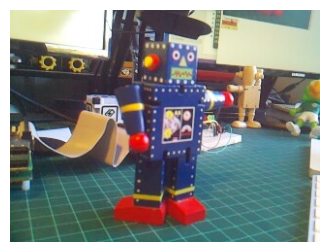

In [77]:
img_path = "./dataset/robot/image_20250819-090431.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	background          : 99.6%
	robot               : 0.0%
	periquito           : 0.0%

	Inference time: 11.0ms


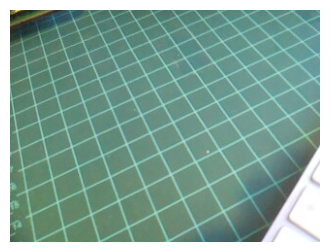

In [78]:
img_path = "./dataset/background/background.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))

## Classifying Images from the Camera

In [79]:
from picamera2 import Picamera2

In [82]:
def capture_image(image_path):
    
  # Initialize camera
  picam2 = Picamera2() # default is index 0

  # Configure the camera
  config = picam2.create_still_configuration(main={"size": (224, 224)})
  picam2.configure(config)
  picam2.start()

  # Wait for the camera to warm up
  time.sleep(2)

  # Capture image
  picam2.capture_file(image_path)
  print("Image captured: "+image_path)

  # Stop camera
  picam2.stop()
  picam2.close()

[20:26:19.458646198] [7182]  INFO Camera camera_manager.cpp:326 libcamera v0.5.1+100-e53bdf1f
[20:26:19.545171634] [7192]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[20:26:19.550520854] [7192]  INFO RPI vc4.cpp:440 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media0 and ISP device /dev/media1
[20:26:19.550629656] [7192]  INFO RPI pipeline_base.cpp:1107 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[20:26:19.570437057] [7182]  INFO Camera camera.cpp:1205 configuring streams: (0) 224x224-BGR888/sRGB (1) 640x480-SGBRG10_CSI2P/RAW
[20:26:19.571196328] [7192]  INFO RPI vc4.cpp:615 Sensor: /base/soc/i2c0mux/i2c@1/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10 - Selected unicam format: 640x480-pGAA


Image captured: ./images/cam_img_test_2.jpg

	[PREDICTION]        [Prob]

	robot               : 99.6%
	periquito           : 0.0%
	background          : 0.0%

	Inference time: 180.9ms


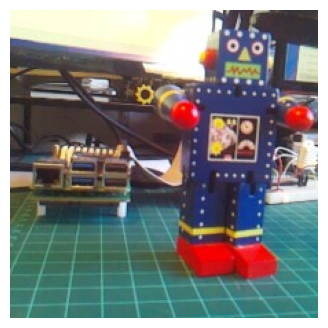

In [86]:
img_path = './images/cam_img_test_2.jpg'
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
capture_image(img_path)
image_classification(img_path, model_path, labels, top_k_results=len(labels))